In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import ariel_load
import tqdm

local


In [2]:
%%time
train_data = kgs.load_all_train_data()
test_data = kgs.load_all_test_data()
len(train_data), len(test_data)

CPU times: user 487 ms, sys: 74.2 ms, total: 562 ms
Wall time: 1.87 s


(1100, 1)

In [3]:
def robust_linear_fit_rms(X, Y, drop_frac=0.05):
    X = np.asarray(X)
    Y = np.asarray(Y)

    # Fit Y = aX + b using least squares
    A = np.vstack([X, np.ones_like(X)]).T
    a, b = np.linalg.lstsq(A, Y, rcond=None)[0]

    # Predicted Y and residuals
    Y_pred = a * X + b
    residuals = Y - Y_pred
    abs_resid = np.abs(residuals)

    # Remove worst 5% (highest absolute residuals)
    if drop_frac>0:
        n = len(residuals)
        keep = int(n * (1 - drop_frac))
        indices = np.argpartition(abs_resid, keep)[:keep]
    #print(keep, len(residuals))
    else:
        indices = np.arange(len(residuals))

    # Compute RMS of the remaining residuals
    rms = np.sqrt(np.mean(residuals[indices] ** 2))
    print(a,b)
    return rms

In [23]:
import ariel_simple
importlib.reload(ariel_simple)
model = ariel_simple.SimpleModel()
model.run_in_parallel = False    
model.train(train_data)
#model.bias_a = [0.,0.]
#model.bias_b = [0.,0.]
data = train_data[:2]
inferred_data = model.infer(data)

Inferring: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.26s/it]


9609.95 19369.95
4069.95 22989.95


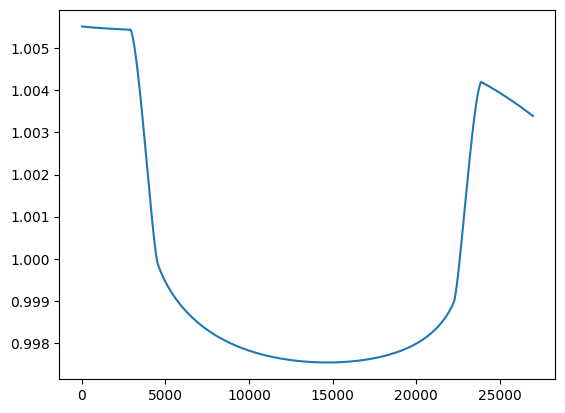

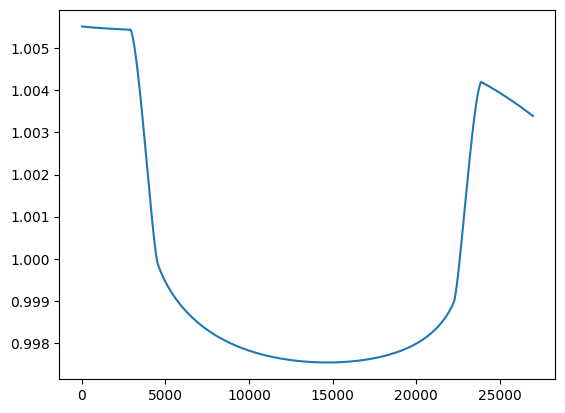

In [24]:
for ii in range(2):
    print(inferred_data[ii].diagnostics['t_ingress'],inferred_data[ii].diagnostics['t_egress'])
    plt.figure()
    plt.plot(model._times[0], model.pred[0])

In [13]:
%debug

> /mnt/d/ariel2/code/core/ariel_simple.py(267)_infer_single()
    265             data.diagnostics['t0'] = self.t0
    266             midpoint = np.min(self.pred[0])/2+np.max(self.pred[0])/2
--> 267             data.diagnostics['t_ingress'] = self._times[np.argwhere(self.pred[0]<midpoint)[0,0]]
    268             data.diagnostics['t_egress'] = self._times[np.argwhere(self.pred[0]<midpoint)[-1,0]]
    269             data.check_constraints()



ipdb>  q


In [4]:
import ariel_simple
importlib.reload(ariel_simple)
df = 0.05
for jj in [0]:
    model = ariel_simple.SimpleModel()
    model.run_in_parallel = True
    match jj:
        case 0:
            name = 'Default'
        case 1:
            name = 'Use correction factor'
            model.use_correction_factor = True        
    model.do_plots = False
    model.train(train_data)
    #model.bias_a = [0.,0.]
    #model.bias_b = [0.,0.]
    data = train_data
    inferred_data = model.infer(data)
    print(name)
    solution = kgs.make_submission_dataframe(data, include_sigma=False)
    submission = kgs.make_submission_dataframe(inferred_data, False)
    print(1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=df), 1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=0))
    print(1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=df),
         1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=0))
    kgs.sanity_checks['simple_residual_diff_FGS'] = kgs.SanityCheckValue('simple_residual_diff_FGS', 12, [-1,1])
    kgs.sanity_checks['simple_residual_diff_FGS'].seen_all = [d.diagnostics['simple_residual_diff_FGS'] for d in inferred_data]
    kgs.sanity_checks['simple_residual_diff_AIRS'] = kgs.SanityCheckValue('simple_residual_diff_AIRS', 12, [-1,1])
    kgs.sanity_checks['simple_residual_diff_AIRS'].seen_all = [d.diagnostics['simple_residual_diff_AIRS'] for d in inferred_data]
    kgs.dill_save(kgs.temp_dir + '/test_simple.pickle', (data,inferred_data,kgs.sanity_checks))

Processing in parallel: 100%|███████████████████████████████████████████████████████| 1100/1100 [07:06<00:00,  2.58it/s]


local
local
local
local
local
local
local
Default
3.9162709864687364e-07 -3.930491800146182e-08
3.9162709864687364e-07 -3.930491800146182e-08
178.54806975268028 296.5617459995472
0.00024068396427757757 2.2345856900438892e-07
0.00024068396427757757 2.2345856900438892e-07
77.8245595507181 200.20723634254654


In [5]:
print(1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=df), 1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=0))
print(1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=df),
    1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=0))

3.9162709864687364e-07 -3.930491800146182e-08
3.9162709864687364e-07 -3.930491800146182e-08
178.54806975268028 296.5617459995472
0.00024068396427757757 2.2345856900438892e-07
0.00024068396427757757 2.2345856900438892e-07
77.8245595507181 200.20723634254654


In [6]:
score, rms_err = kgs.score_metric(inferred_data, data)
#np.sqrt(np.diag(inferred_data[0].spectrum_cov))

Score:     0.4125
RMS error: 497.9653 ppm


In [7]:
import copy
data_sim = copy.deepcopy(data)
sig = rms_err
for ii,d in enumerate(data_sim):
    d.spectrum += np.random.default_rng(seed=ii).normal(0,sig,size=d.spectrum.shape)
    d.spectrum_cov = np.diag(0*d.spectrum+sig**2)
    d.check_constraints()
print('Theoretical')
kgs.score_metric(data_sim, data);

Theoretical
Score:     0.3834
RMS error: 497.5224 ppm


In [8]:
kgs.print_sanity_checks()

simple_residual_diff_FGS [inf, -inf] [-1, 1] 12
simple_residual_diff_AIRS [inf, -inf] [-1, 1] 12


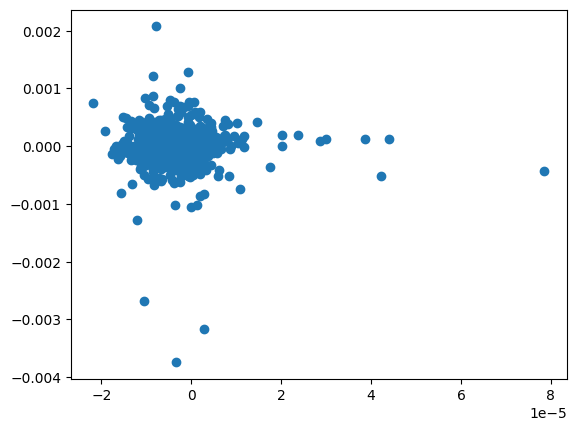

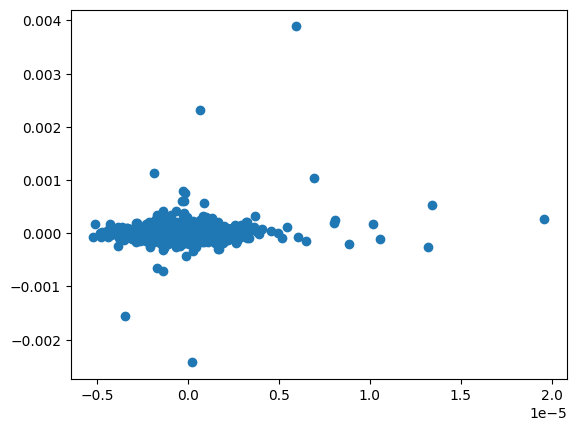

In [9]:
plt.figure();
plt.scatter(kgs.sanity_checks['simple_residual_diff_FGS'].seen_all, solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy())
plt.figure();
plt.scatter(kgs.sanity_checks['simple_residual_diff_AIRS'].seen_all, np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1))

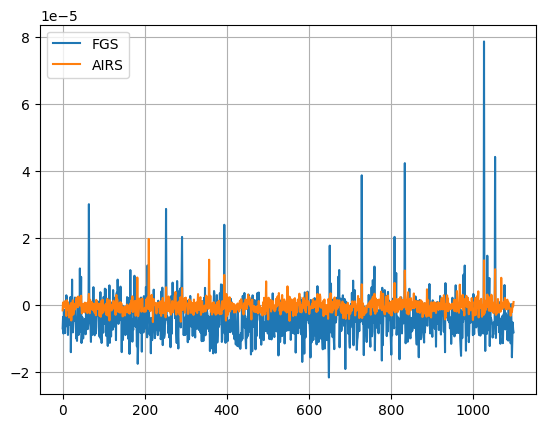

In [10]:
plt.figure()
plt.plot(kgs.sanity_checks['simple_residual_diff_FGS'].seen_all)
plt.plot(kgs.sanity_checks['simple_residual_diff_AIRS'].seen_all)
plt.legend(('FGS', 'AIRS'))
plt.grid(True)

In [11]:
solution = kgs.make_submission_dataframe(data, include_sigma=False)
submission = kgs.make_submission_dataframe(inferred_data, False)


In [12]:
kgs.rms(solution.iloc[:,1:2].to_numpy()-submission.iloc[:,1:2].to_numpy()),kgs.rms(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy())

(0.0002965617479304045, 0.0004985347627283622)

Text(0.5, 1.0, '498.5347627283621')

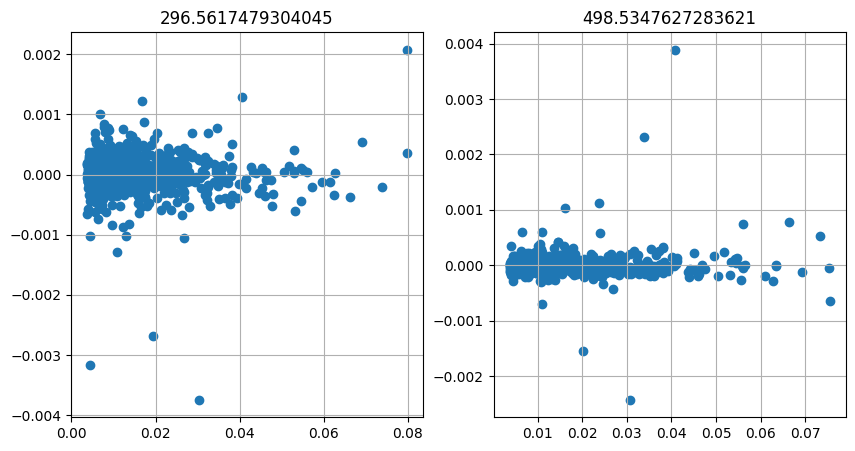

In [13]:
_,ax=plt.subplots(1,2,figsize=(10,5))
plt.sca(ax[0])
plt.box(True);plt.grid(True);
plt.scatter(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy())
plt.title(1e6*kgs.rms(solution.iloc[:,1:2].to_numpy()-submission.iloc[:,1:2].to_numpy()))
plt.sca(ax[1])
plt.box(True);plt.grid(True);
plt.scatter(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1))
plt.title(1e6*kgs.rms(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy()))

In [14]:
ind = np.argmax(np.abs(np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1)))
ind

968

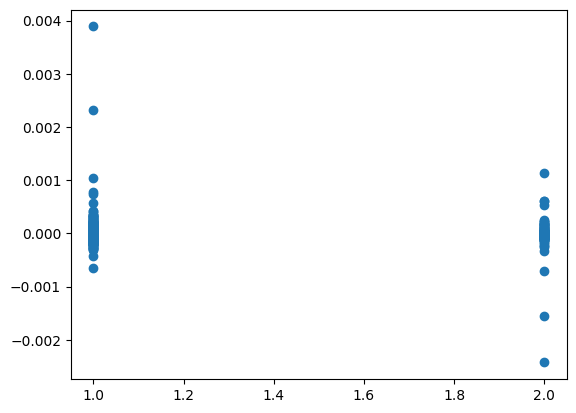

In [15]:
plt.scatter([len(d.transits) for d in train_data],np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1))

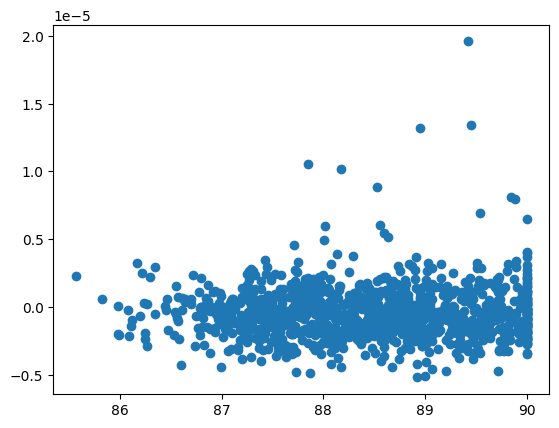

In [16]:
plt.scatter([d.i for d in train_data],kgs.sanity_checks['simple_residual_diff_AIRS'].seen_all)

In [9]:
import ariel_simple
importlib.reload(ariel_simple)
df = 0.05
model = ariel_simple.SimpleModel()
model.run_in_parallel = True  
model.do_plots = False
#model.bias_a = [0.,0.]
#model.bias_b = [0.,0.]
data = train_data[:50]
model.train(data)
inferred_data = model.infer(data)
solution = kgs.make_submission_dataframe(data, include_sigma=False)
submission = kgs.make_submission_dataframe(inferred_data, False)
print(1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=df), 1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=0))
print(1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=df),
     1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=0))
kgs.score_metric(inferred_data,data)

Processing in parallel:   0%|                                                                    | 0/50 [00:00<?, ?it/s]

local
local
local
local
local
local
local


Processing in parallel: 100%|███████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.50it/s]


-0.004084014736958795 9.124530968324333e-05
-0.004084014736958795 9.124530968324333e-05
179.81366971357096 275.648115828812
-0.005413469729796693 8.435034846667058e-05
-0.005413469729796693 8.435034846667058e-05
96.37765685815688 141.65688480692776
Score:     0.4227
RMS error: 264.0291 ppm


(0.4227001116451747, 0.0002640290734865416)

In [35]:
import ariel_model
importlib.reload(ariel_model)
df = 0.05
model = ariel_simple.SimpleModel()
model.run_in_parallel = True  
model.do_plots = False
model.bias_a = [0.,0.]
model.bias_b = [0.,0.]
model = ariel_model.Fudger(model=model)
data = train_data[:5]
print('5')
model.train(data)
inferred_data = model.infer(data)
solution = kgs.make_submission_dataframe(data, include_sigma=False)
submission = kgs.make_submission_dataframe(inferred_data, False)
print(1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=df), 1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=0))
print(1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=df),
     1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=0))
kgs.score_metric(inferred_data,data)

5


Processing in parallel:   0%|                                                                     | 0/5 [00:00<?, ?it/s]

local
locallocal

local
local


Processing in parallel: 100%|█████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


Opt time 24.46068572998047
8.074822868172645e-05 -4.9519672338724586e-06
8.074822868172645e-05 -4.9519672338724586e-06
111.26711066997413 177.07780324897152
0.0002671268702826935 -9.933321229567903e-07
0.0002671268702826935 -9.933321229567903e-07
68.66846962494677 90.75823352420507
Score:     0.5620
RMS error: 142.0940 ppm


(0.5620194638438952, 0.00014209396261006827)

In [29]:
model.sigma_fudge

[0.5969662460611648, 0.2824782899583849]

In [24]:
%debug

> /mnt/d/ariel2/code/core/ariel_model.py(22)_from_x()
     20         return np.reshape([self.bias_a + self.bias_b + self.sigma_fudge], (-1,))
     21     def _from_x(self,x):
---> 22         self.bias_a[0] = x[0]
     23         self.bias_a[1] = x[1]
     24         self.bias_b[0] = x[2]



ipdb>  x


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.5620194639205984
        x: [ 9.892e-01  9.780e-01  1.876e-04  1.309e-04  5.970e-01
             2.825e-01]
      nit: 26
      jac: [ 2.973e-06  8.717e-06  1.607e-04  6.759e-04 -7.451e-09
             1.937e-07]
 hess_inv: [[ 1.124e-02 -3.408e-06 ...  3.219e-03 -1.423e-04]
            [-3.408e-06  1.032e-03 ... -6.677e-04 -3.830e-04]
            ...
            [ 3.219e-03 -6.677e-04 ...  1.060e+01 -7.080e-03]
            [-1.423e-04 -3.830e-04 ... -7.080e-03  3.546e-01]]
     nfev: 453
     njev: 63


ipdb>  x.x


array([9.89230513e-01, 9.78022330e-01, 1.87563354e-04, 1.30862605e-04,
       5.96966246e-01, 2.82478290e-01])


ipdb>  q
